## Import and Installing Dependencies

In [1]:
!pip install kagglehub pandas matplotlib seaborn numpy scikit-learn

In [2]:
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

## Loading Dataset

#### Via Kagglehub

In [3]:
path = kagglehub.dataset_download("zeesolver/consumer-behavior-and-shopping-habits-dataset")
print("Path to dataset files:", path)
csv_file = os.path.join(path, 'shopping_behavior_updated.csv')
df = pd.read_csv(csv_file)

Path to dataset files: C:\Users\kalat\.cache\kagglehub\datasets\zeesolver\consumer-behavior-and-shopping-habits-dataset\versions\1


#### Directly from Website

###### E-Commerce Customer Data --> https://www.kaggle.com/datasets/zeesolver/consumer-behavior-and-shopping-habits-dataset

## Data Preprocessing

In [4]:
dataset = df.copy()

#### Understanding Data

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used         3900 non-null   

#### Statistical Analysis

In [6]:
dataset.describe()

,Customer ID,Age,Purchase Amount (USD),Review Rating,Previous Purchases
count,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000
mean,1950.500000,44.068462,59.764359,3.749949,25.351538
std,1125.977353,15.207589,23.685392,0.716223,14.447125
min,1.000000,18.000000,20.000000,2.500000,1.000000
25%,975.750000,31.000000,39.000000,3.100000,13.000000
50%,1950.500000,44.000000,60.000000,3.700000,25.000000
75%,2925.250000,57.000000,81.000000,4.400000,38.000000
max,3900.000000,70.000000,100.000000,5.000000,50.000000


In [7]:
dataset.shape

(3900, 18)

#### Null Value Handling

In [8]:
dataset.isnull().sum()

Customer ID               0
Age                       0
Gender                    0
Item Purchased            0
Category                  0
Purchase Amount (USD)     0
Location                  0
Size                      0
Color                     0
Season                    0
Review Rating             0
Subscription Status       0
Shipping Type             0
Discount Applied          0
Promo Code Used           0
Previous Purchases        0
Payment Method            0
Frequency of Purchases    0
dtype: int64

###### Nothing to do because no null values

#### Handling Duplicate Values

In [9]:
dataset.duplicated().sum()

0

###### Nothing to do because no duplicated rows

In [10]:
dataset.head(5)

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually


#### Outlier Handling

In [11]:
def check_outliers_and_handle(dataset_name, list_of_columns) :
    for i in list_of_columns :
        iqr = dataset_name[i].quantile(.75) - dataset_name[i].quantile(.25)
        q1 = dataset_name[i].quantile(.25)
        q3 = dataset_name[i].quantile(.75)
        lowest_allowed = q1 - 1.5 * iqr
        highest_allowed = q3 + 1.5 * iqr
        
        count = 0
        for x in dataset_name[i] :
           if x < lowest_allowed or x > highest_allowed:
               count = count + 1
        print('Total Number of Outliers in', i, 'before handling is :', count)

        dataset_name[i] = np.where(dataset_name[i] > highest_allowed, highest_allowed,
                                  np.where(dataset_name[i] < lowest_allowed, lowest_allowed,
                                          dataset_name[i]))

        count_a = 0
        for y in dataset_name[i] :
           if y < lowest_allowed or y > highest_allowed:
               count_a = count_a + 1
        print('Total Number of Outliers in', i, 'after handling is :', count_a)

In [12]:
to_check = ['Purchase Amount (USD)']
check_outliers_and_handle(dataset, to_check)

Total Number of Outliers in Purchase Amount (USD) before handling is : 0
Total Number of Outliers in Purchase Amount (USD) after handling is : 0


###### No Outliers Found

In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   float64
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used         3900 non-null   

#### Handling categorical Data

In [14]:
def handle_categorical_label(dataset_name, list_of_columns):
    label_encoder = LabelEncoder()
    for column in list_of_columns :
        dataset_name[column] = label_encoder.fit_transform(dataset_name[column])  

In [15]:
categorical_columns = ['Gender', 'Item Purchased', 'Category', 'Location', 'Size', 'Color', 'Season', 'Subscription Status',
                      'Shipping Type', 'Discount Applied', 'Promo Code Used', 'Payment Method', 'Frequency of Purchases']

In [16]:
handle_categorical_label(dataset, categorical_columns)

In [17]:
dataset.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,1,2,1,53.0,16,0,7,3,3.1,1,1,1,1,14,5,3
1,2,19,1,23,1,64.0,18,0,12,3,3.1,1,1,1,1,2,1,3
2,3,50,1,11,1,73.0,20,2,12,1,3.1,1,2,1,1,23,2,6
3,4,21,1,14,2,90.0,38,1,12,1,3.5,1,3,1,1,49,4,6
4,5,45,1,2,1,49.0,36,1,21,1,2.7,1,2,1,1,31,4,0


## Exploratory Data Anacondalysis (EDA)

In [18]:
def plot_dist(column_no, raw_no, dataset) :
    plt.figure(figsize=(12, 22))
    for i in range(1, (raw_no * column_no)) :
        plt.subplot(raw_no, column_no, i + 1)
        sns.histplot(dataset.iloc[:, [i]], kde = True)
        plt.title(i)

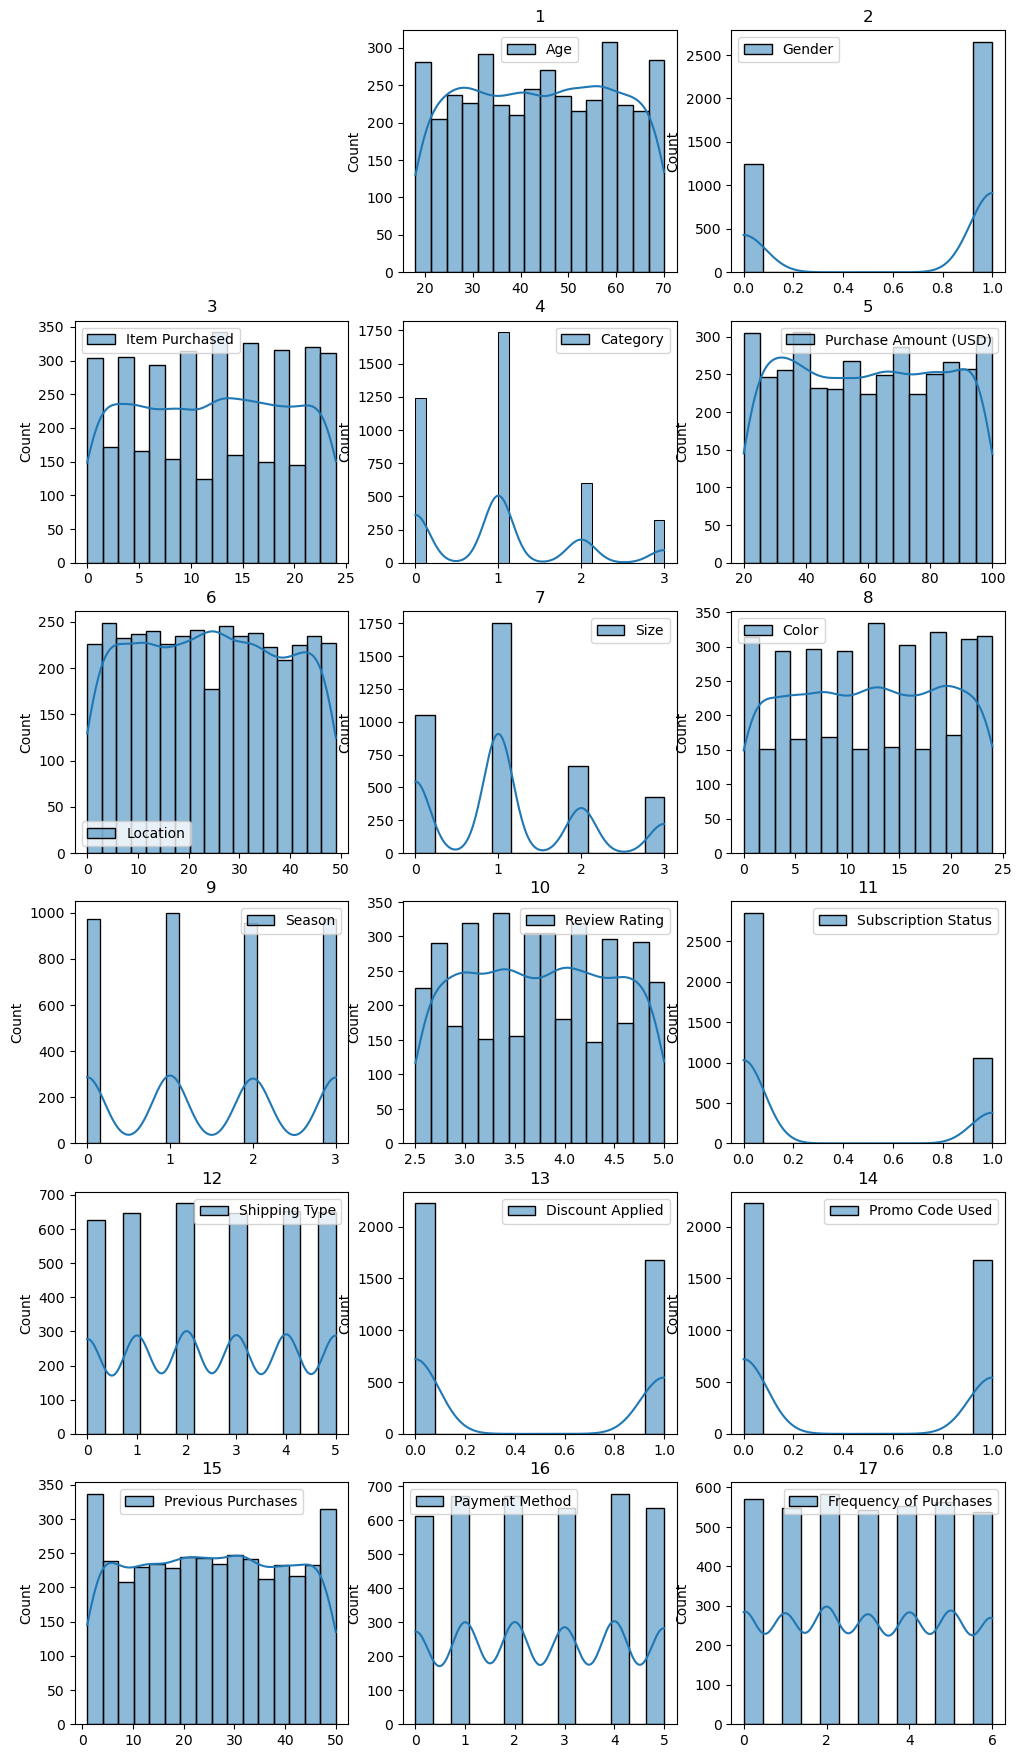

In [19]:
plot_dist(3, 6, dataset)

In [20]:
data_copy = dataset.copy()

#### Scaling Numeric Data

###### Here MinMaxScaling is applied because none of the numeric column is Normally distributed, if it was normally distribued then Standardscaling would have been better option 

In [21]:
def handle_numeric_columns(dataset_name, list_of_columns) :
    minmax_scaler = MinMaxScaler()
    for column in list_of_columns :
        dataset_name[column] = minmax_scaler.fit_transform(dataset_name[[column]])

In [22]:
numeric_columns = data_copy.columns.tolist()
handle_numeric_columns(data_copy, numeric_columns)

In [23]:
data_copy.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,0.000000,0.711538,1.0,0.083333,0.333333,0.4125,0.326531,0.000000,0.291667,1.000000,0.24,1.0,0.2,1.0,1.0,0.265306,1.0,0.5
1,0.000256,0.019231,1.0,0.958333,0.333333,0.5500,0.367347,0.000000,0.500000,1.000000,0.24,1.0,0.2,1.0,1.0,0.020408,0.2,0.5
2,0.000513,0.615385,1.0,0.458333,0.333333,0.6625,0.408163,0.666667,0.500000,0.333333,0.24,1.0,0.4,1.0,1.0,0.448980,0.4,1.0
3,0.000769,0.057692,1.0,0.583333,0.666667,0.8750,0.775510,0.333333,0.500000,0.333333,0.40,1.0,0.6,1.0,1.0,0.979592,0.8,1.0
4,0.001026,0.519231,1.0,0.083333,0.333333,0.3625,0.734694,0.333333,0.875000,0.333333,0.08,1.0,0.4,1.0,1.0,0.612245,0.8,0.0


#### Droping irrelevant columns

In [24]:
data_copy = data_copy.drop(columns = 'Customer ID', axis = 1)

In [25]:
data_copy.head()

,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,0.711538,1.0,0.083333,0.333333,0.4125,0.326531,0.000000,0.291667,1.000000,0.24,1.0,0.2,1.0,1.0,0.265306,1.0,0.5
1,0.019231,1.0,0.958333,0.333333,0.5500,0.367347,0.000000,0.500000,1.000000,0.24,1.0,0.2,1.0,1.0,0.020408,0.2,0.5
2,0.615385,1.0,0.458333,0.333333,0.6625,0.408163,0.666667,0.500000,0.333333,0.24,1.0,0.4,1.0,1.0,0.448980,0.4,1.0
3,0.057692,1.0,0.583333,0.666667,0.8750,0.775510,0.333333,0.500000,0.333333,0.40,1.0,0.6,1.0,1.0,0.979592,0.8,1.0
4,0.519231,1.0,0.083333,0.333333,0.3625,0.734694,0.333333,0.875000,0.333333,0.08,1.0,0.4,1.0,1.0,0.612245,0.8,0.0


## Clustering (Label and MinMax)

In [26]:
k_means = KMeans(5)

In [27]:
data_copy['Cluster'] = k_means.fit_predict(data_copy)

#### Evaluation

In [28]:
print('Silhouette Score of Cluster     :', silhouette_score(data_copy, k_means.labels_))
print('Davies Bouldin Score of Cluster :', davies_bouldin_score(data_copy, k_means.labels_))

Silhouette Score of Cluster     : 0.35604990812349463
Davies Bouldin Score of Cluster : 1.2544295056674393


In [29]:
data_copy.head()

,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases,Cluster
0,0.711538,1.0,0.083333,0.333333,0.4125,0.326531,0.000000,0.291667,1.000000,0.24,1.0,0.2,1.0,1.0,0.265306,1.0,0.5,1
1,0.019231,1.0,0.958333,0.333333,0.5500,0.367347,0.000000,0.500000,1.000000,0.24,1.0,0.2,1.0,1.0,0.020408,0.2,0.5,1
2,0.615385,1.0,0.458333,0.333333,0.6625,0.408163,0.666667,0.500000,0.333333,0.24,1.0,0.4,1.0,1.0,0.448980,0.4,1.0,4
3,0.057692,1.0,0.583333,0.666667,0.8750,0.775510,0.333333,0.500000,0.333333,0.40,1.0,0.6,1.0,1.0,0.979592,0.8,1.0,4
4,0.519231,1.0,0.083333,0.333333,0.3625,0.734694,0.333333,0.875000,0.333333,0.08,1.0,0.4,1.0,1.0,0.612245,0.8,0.0,4


### PCA

In [30]:
pca = PCA(n_components = 3)
new_data = pd.DataFrame(pca.fit_transform(data_copy.iloc[:, :-1]), columns = ['PC-1', 'PC-2', 'PC-3'])
new_data['Cluster'] = data_copy['Cluster']

In [31]:
new_data.head()

,PC-1,PC-2,PC-3,Cluster
0,1.093190,0.343754,-0.389928,1
1,1.081132,0.432954,-0.318723,1
2,1.089658,-0.211039,-0.082867,4
3,1.099206,-0.152338,-0.173595,4
4,1.096965,-0.273357,-0.276871,4


#### Visualizing PCA components

<Axes: xlabel='PC-2', ylabel='PC-3'>

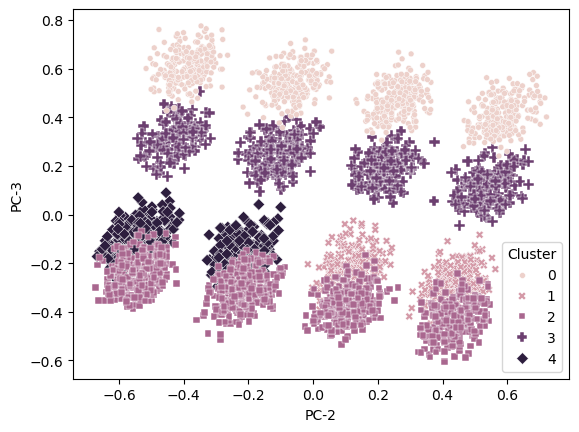

In [32]:
sns.scatterplot(new_data, x = 'PC-2', y = 'PC-3', hue = 'Cluster', style = 'Cluster', size = 'Cluster')

In [33]:
dataset.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,1,2,1,53.0,16,0,7,3,3.1,1,1,1,1,14,5,3
1,2,19,1,23,1,64.0,18,0,12,3,3.1,1,1,1,1,2,1,3
2,3,50,1,11,1,73.0,20,2,12,1,3.1,1,2,1,1,23,2,6
3,4,21,1,14,2,90.0,38,1,12,1,3.5,1,3,1,1,49,4,6
4,5,45,1,2,1,49.0,36,1,21,1,2.7,1,2,1,1,31,4,0


In [34]:
data_raw = dataset.copy()

## Clustering (only Label encoding)

In [35]:
k_means_raw = KMeans(5)
data_raw['Cluster'] = k_means_raw.fit_predict(data_raw)

In [36]:
data_raw.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases,Cluster
0,1,55,1,2,1,53.0,16,0,7,3,3.1,1,1,1,1,14,5,3,0
1,2,19,1,23,1,64.0,18,0,12,3,3.1,1,1,1,1,2,1,3,0
2,3,50,1,11,1,73.0,20,2,12,1,3.1,1,2,1,1,23,2,6,0
3,4,21,1,14,2,90.0,38,1,12,1,3.5,1,3,1,1,49,4,6,0
4,5,45,1,2,1,49.0,36,1,21,1,2.7,1,2,1,1,31,4,0,0


#### Evaluation

In [37]:
print('Silhouette Score of Cluster     :', silhouette_score(data_raw, k_means_raw.labels_))
print('Davies Bouldin Score of Cluster :', davies_bouldin_score(data_raw, k_means_raw.labels_))

Silhouette Score of Cluster     : 0.5478069001944436
Davies Bouldin Score of Cluster : 0.5153663364573339


### PCA

In [38]:
pca_raw = PCA(3)
new_data_raw = pd.DataFrame(pca_raw.fit_transform(data_raw.iloc[:, :-1]), columns = ['PC-1', 'PC-2', 'PC-3'])
new_data_raw['Cluster'] = data_raw['Cluster']

In [39]:
new_data_raw.head()

,PC-1,PC-2,PC-3,Cluster
0,-1949.494925,-6.733937,6.625714,0
1,-1948.484466,4.588324,-31.224586,0
2,-1947.495340,13.465744,4.887952,0
3,-1946.505905,31.459529,-14.811617,0
4,-1945.508136,-9.959911,1.241443,0


#### Visualizing PCA components

<Axes: xlabel='PC-1', ylabel='PC-2'>

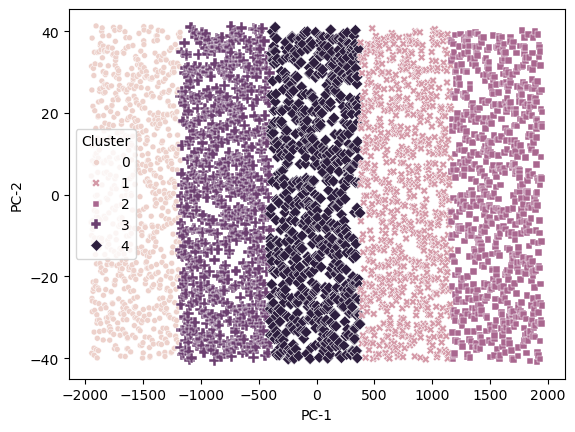

In [40]:
sns.scatterplot(new_data_raw, x = 'PC-1', y = 'PC-2', hue = 'Cluster', style = 'Cluster', size = 'Cluster')

In [41]:
data = df.copy()

In [42]:
data.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually


#### Doing Differently this time

## Data Preprocessing

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used         3900 non-null   

#### Mapping feature according to categorical weights

In [44]:
print('Types of Frequency Purchase :', data['Frequency of Purchases'].unique())
print('Types of Sizes', data['Size'].unique())
print('Subscription Status', data['Subscription Status'].unique())
print('Gender', data['Gender'].unique())

Types of Frequency Purchase : ['Fortnightly' 'Weekly' 'Annually' 'Quarterly' 'Bi-Weekly' 'Monthly'
 'Every 3 Months']
Types of Sizes ['L' 'S' 'M' 'XL']
Subscription Status ['Yes' 'No']
Gender ['Male' 'Female']


In [45]:
frequency_mapping = {
    'Weekly'        : 52,
    'Fortnightly'   : 26,
    'Bi-Weekly'     : 26,
    'Monthly'       : 12,
    'Every 3 Months': 4,
    'Quarterly'     : 4,
    'Annually'      : 1
}

size_mapping = {
    'S'  : 1,
    'M'  : 2,
    'L'  : 3,
    'XL' : 4
}

subscription_mapping = {
    'Yes' : 1,
    'No'  : 0
}

gender_mapping = {
    'Male'   : 1,
    'Female' : 0
}

discount_mapping = {
    'Yes' : 1,
    'No'  : 0
}

promo_mapping = {
    'Yes' : 1,
    'No'  : 0
}

In [46]:
data['Frequency of Purchases'] = data['Frequency of Purchases'].map(frequency_mapping)
data['Size']                   = data['Size'].map(size_mapping)
data['Subscription Status']    = data['Subscription Status'].map(subscription_mapping)
data['Gender']                 = data['Gender'].map(gender_mapping)
data['Discount Applied']       = data['Discount Applied'].map(discount_mapping)
data['Promo Code Used']        = data['Promo Code Used'].map(promo_mapping)

In [47]:
data.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,1,Blouse,Clothing,53,Kentucky,3,Gray,Winter,3.1,1,Express,1,1,14,Venmo,26
1,2,19,1,Sweater,Clothing,64,Maine,3,Maroon,Winter,3.1,1,Express,1,1,2,Cash,26
2,3,50,1,Jeans,Clothing,73,Massachusetts,1,Maroon,Spring,3.1,1,Free Shipping,1,1,23,Credit Card,52
3,4,21,1,Sandals,Footwear,90,Rhode Island,2,Maroon,Spring,3.5,1,Next Day Air,1,1,49,PayPal,52
4,5,45,1,Blouse,Clothing,49,Oregon,2,Turquoise,Spring,2.7,1,Free Shipping,1,1,31,PayPal,1


#### Droping irrelevant columns

In [48]:
data = data.drop(columns = ['Customer ID', 'Location', 'Shipping Type', 'Payment Method'], axis = 1)

In [49]:
data.head()

,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Size,Color,Season,Review Rating,Subscription Status,Discount Applied,Promo Code Used,Previous Purchases,Frequency of Purchases
0,55,1,Blouse,Clothing,53,3,Gray,Winter,3.1,1,1,1,14,26
1,19,1,Sweater,Clothing,64,3,Maroon,Winter,3.1,1,1,1,2,26
2,50,1,Jeans,Clothing,73,1,Maroon,Spring,3.1,1,1,1,23,52
3,21,1,Sandals,Footwear,90,2,Maroon,Spring,3.5,1,1,1,49,52
4,45,1,Blouse,Clothing,49,2,Turquoise,Spring,2.7,1,1,1,31,1


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     3900 non-null   int64  
 1   Gender                  3900 non-null   int64  
 2   Item Purchased          3900 non-null   object 
 3   Category                3900 non-null   object 
 4   Purchase Amount (USD)   3900 non-null   int64  
 5   Size                    3900 non-null   int64  
 6   Color                   3900 non-null   object 
 7   Season                  3900 non-null   object 
 8   Review Rating           3900 non-null   float64
 9   Subscription Status     3900 non-null   int64  
 10  Discount Applied        3900 non-null   int64  
 11  Promo Code Used         3900 non-null   int64  
 12  Previous Purchases      3900 non-null   int64  
 13  Frequency of Purchases  3900 non-null   int64  
dtypes: float64(1), int64(9), object(4)
memor

#### Handling Categorical Columns

In [51]:
cat_columns = ['Item Purchased', 'Category', 'Color', 'Season']
handle_categorical_label(data, cat_columns)

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     3900 non-null   int64  
 1   Gender                  3900 non-null   int64  
 2   Item Purchased          3900 non-null   int32  
 3   Category                3900 non-null   int32  
 4   Purchase Amount (USD)   3900 non-null   int64  
 5   Size                    3900 non-null   int64  
 6   Color                   3900 non-null   int32  
 7   Season                  3900 non-null   int32  
 8   Review Rating           3900 non-null   float64
 9   Subscription Status     3900 non-null   int64  
 10  Discount Applied        3900 non-null   int64  
 11  Promo Code Used         3900 non-null   int64  
 12  Previous Purchases      3900 non-null   int64  
 13  Frequency of Purchases  3900 non-null   int64  
dtypes: float64(1), int32(4), int64(9)
memory

In [53]:
data1 = data.copy()

In [54]:
data1.head()

,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Size,Color,Season,Review Rating,Subscription Status,Discount Applied,Promo Code Used,Previous Purchases,Frequency of Purchases
0,55,1,2,1,53,3,7,3,3.1,1,1,1,14,26
1,19,1,23,1,64,3,12,3,3.1,1,1,1,2,26
2,50,1,11,1,73,1,12,1,3.1,1,1,1,23,52
3,21,1,14,2,90,2,12,1,3.5,1,1,1,49,52
4,45,1,2,1,49,2,21,1,2.7,1,1,1,31,1


## Clustering (Label and mapping)

In [55]:
k_m = KMeans(5)
data1['Cluster'] = k_m.fit_predict(data1)

#### Evaluation

In [56]:
print('Silhouette Score of Cluster     :', silhouette_score(data1, k_m.labels_))
print('Davies Bouldin Score of Cluster :', davies_bouldin_score(data1, k_m.labels_))

Silhouette Score of Cluster     : 0.17905618950215746
Davies Bouldin Score of Cluster : 1.6932992155883952


### PCA

In [57]:
pca1_ = PCA(3)
data1_ = pd.DataFrame(pca1_.fit_transform(data1.iloc[:, :-1]), columns = ['PC-1', 'PC-2', 'PC-3'])
data1_['Cluster'] = data1['Cluster']

In [58]:
data1_.head()

,PC-1,PC-2,PC-3,Cluster
0,-7.106221,8.097171,6.524877,4
1,4.156300,8.471428,-31.323266,3
2,12.503412,34.692614,4.929759,0
3,30.010449,35.553464,-13.782896,0
4,-10.416355,-16.641645,2.695792,4


#### Visualizing PCA components

<Axes: xlabel='PC-1', ylabel='PC-2'>

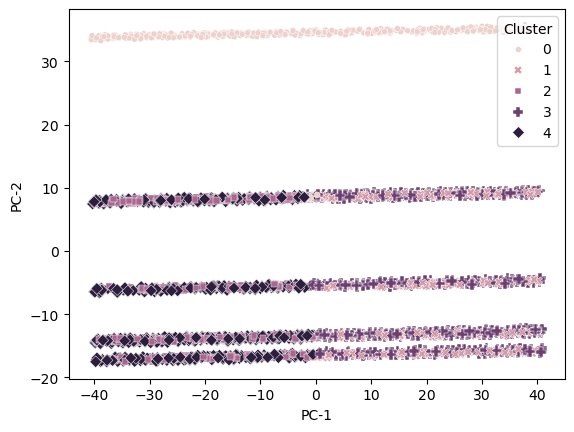

In [59]:
sns.scatterplot(data1_, x = 'PC-1', y = 'PC-2', hue = 'Cluster', style = 'Cluster', size = 'Cluster')

In [60]:
data2 = data.copy()

In [61]:
data2.head()

,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Size,Color,Season,Review Rating,Subscription Status,Discount Applied,Promo Code Used,Previous Purchases,Frequency of Purchases
0,55,1,2,1,53,3,7,3,3.1,1,1,1,14,26
1,19,1,23,1,64,3,12,3,3.1,1,1,1,2,26
2,50,1,11,1,73,1,12,1,3.1,1,1,1,23,52
3,21,1,14,2,90,2,12,1,3.5,1,1,1,49,52
4,45,1,2,1,49,2,21,1,2.7,1,1,1,31,1


#### MinMax Scalling

In [62]:
numeric_col = data2.columns
handle_numeric_columns(data2, numeric_col)

In [63]:
data2.head()

,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Size,Color,Season,Review Rating,Subscription Status,Discount Applied,Promo Code Used,Previous Purchases,Frequency of Purchases
0,0.711538,1.0,0.083333,0.333333,0.4125,0.666667,0.291667,1.000000,0.24,1.0,1.0,1.0,0.265306,0.490196
1,0.019231,1.0,0.958333,0.333333,0.5500,0.666667,0.500000,1.000000,0.24,1.0,1.0,1.0,0.020408,0.490196
2,0.615385,1.0,0.458333,0.333333,0.6625,0.000000,0.500000,0.333333,0.24,1.0,1.0,1.0,0.448980,1.000000
3,0.057692,1.0,0.583333,0.666667,0.8750,0.333333,0.500000,0.333333,0.40,1.0,1.0,1.0,0.979592,1.000000
4,0.519231,1.0,0.083333,0.333333,0.3625,0.333333,0.875000,0.333333,0.08,1.0,1.0,1.0,0.612245,0.000000


## Clustering (Label and MinMax(mapped weights))

In [64]:
k_m2 = KMeans(5)
data2['Cluster'] = k_m2.fit_predict(data2)

In [65]:
data2.head()

,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Size,Color,Season,Review Rating,Subscription Status,Discount Applied,Promo Code Used,Previous Purchases,Frequency of Purchases,Cluster
0,0.711538,1.0,0.083333,0.333333,0.4125,0.666667,0.291667,1.000000,0.24,1.0,1.0,1.0,0.265306,0.490196,4
1,0.019231,1.0,0.958333,0.333333,0.5500,0.666667,0.500000,1.000000,0.24,1.0,1.0,1.0,0.020408,0.490196,4
2,0.615385,1.0,0.458333,0.333333,0.6625,0.000000,0.500000,0.333333,0.24,1.0,1.0,1.0,0.448980,1.000000,0
3,0.057692,1.0,0.583333,0.666667,0.8750,0.333333,0.500000,0.333333,0.40,1.0,1.0,1.0,0.979592,1.000000,0
4,0.519231,1.0,0.083333,0.333333,0.3625,0.333333,0.875000,0.333333,0.08,1.0,1.0,1.0,0.612245,0.000000,0


#### Evaluation

In [66]:
print('Silhouette Score of Cluster     :', silhouette_score(data2, k_m.labels_))
print('Davies Bouldin Score of Cluster :', davies_bouldin_score(data2, k_m.labels_))

Silhouette Score of Cluster     : 0.018833984471090238
Davies Bouldin Score of Cluster : 6.083856117588525


### PCA

In [67]:
pca2_ = PCA(3)
data2_ = pd.DataFrame(pca2_.fit_transform(data2.iloc[:, :-1]), columns = ['PC-1', 'PC-2', 'PC-3'])
data2_['Cluster'] = data2['Cluster']

In [68]:
data2_.head()

,PC-1,PC-2,PC-3,Cluster
0,1.093033,0.433104,-0.304746,4
1,1.086163,0.479290,-0.327976,4
2,1.093466,-0.205809,-0.238691,0
3,1.095230,-0.134727,-0.244549,0
4,1.097355,-0.244409,-0.167717,0


#### Visualizing PCA components

<Axes: xlabel='PC-3', ylabel='PC-2'>

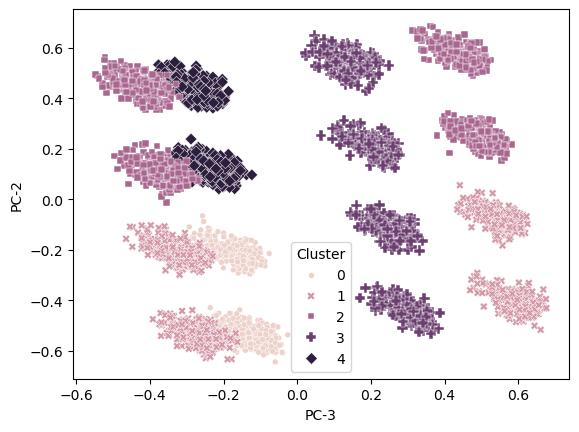

In [69]:
sns.scatterplot(data2_, x = 'PC-3', y = 'PC-2', hue = 'Cluster', style = 'Cluster', size = 'Cluster')

## Comparative Analysis

In [70]:
print('Clustering using Label and Minmax(simple)')
print('Silhouette Score of Cluster     :', silhouette_score(data_copy, k_means.labels_))
print('Davies Bouldin Score of Cluster :', davies_bouldin_score(data_copy, k_means.labels_))
print('*' * 100)

print('Clustering using only Label(simple)')
print('Silhouette Score of Cluster     :', silhouette_score(data_raw, k_means_raw.labels_))
print('Davies Bouldin Score of Cluster :', davies_bouldin_score(data_raw, k_means_raw.labels_))
print('*' * 100)

print('Clustering using Label and Weight Mapping')
print('Silhouette Score of Cluster     :', silhouette_score(data1, k_m.labels_))
print('Davies Bouldin Score of Cluster :', davies_bouldin_score(data1, k_m.labels_))
print('*' * 100)

print('Clustering using Label and MinMax(Weight Mapping)')
print('Silhouette Score of Cluster     :', silhouette_score(data2, k_m.labels_))
print('Davies Bouldin Score of Cluster :', davies_bouldin_score(data2, k_m.labels_))

Clustering using Label and Minmax(simple)
Silhouette Score of Cluster     : 0.35604990812349463
Davies Bouldin Score of Cluster : 1.2544295056674393
****************************************************************************************************
Clustering using only Label(simple)
Silhouette Score of Cluster     : 0.5478069001944436
Davies Bouldin Score of Cluster : 0.5153663364573339
****************************************************************************************************
Clustering using Label and Weight Mapping
Silhouette Score of Cluster     : 0.17905618950215746
Davies Bouldin Score of Cluster : 1.6932992155883952
****************************************************************************************************
Clustering using Label and MinMax(Weight Mapping)
Silhouette Score of Cluster     : 0.018833984471090238
Davies Bouldin Score of Cluster : 6.083856117588525


##### From above comparative analysis we can see that Clustering in which only encoded categorical data using Label Encoding and done anything to numeric data is segmenting customers better 